In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Basket')

In [3]:
data = dm.__get_data__()

In [4]:
data.head()

odds        \
                                                                      0     1   
MatchDate  HomeTeam            AwayTeam           bkmr                          
2009-10-27 Cleveland Cavaliers Boston Celtics     bet365_op_ha_    2.70  1.50   
                                                  pinnacle_op_ha_  2.80  1.51   
           Dallas Mavericks    Washington Wizards bet365_op_ha_    4.20  1.25   
                                                  pinnacle_op_ha_  4.40  1.27   
2009-10-28 Atlanta Hawks       Indiana Pacers     bet365_op_ha_    4.25  1.23   

                                                                   prob        \
                                                                      0     1   
MatchDate  HomeTeam            AwayTeam           bkmr                          
2009-10-27 Cleveland Cavaliers Boston Celtics     bet365_op_ha_    0.36  0.64   
                                                  pinnacle_op_ha_  0.35  0.65   
           Dallas Mavericks    Washington Wizards bet365_op_ha_    0.23  0.77   
                                                  pinnacle_op_ha_  0.22  0.78   
2009-10-28 Atlanta Hawks       Indiana Pacers     bet365_op_ha_    0.22  0.78   

                                                                    book FTR  
                                                                              
MatchDate  HomeTeam            AwayTeam           bkmr                        
2009-10-27 Cleveland Cavaliers Boston Celtics     bet365_op_ha_    0.037   0  
                                                  pinnacle_op_ha_  0.019   0  
           Dallas Mavericks    Washington Wizards bet365_op_ha_    0.038   0  
                                                  pinnacle_op_ha_  0.015   0  
2009-10-28 Atlanta Hawks       Indiana Pacers     bet365_op_ha_    0.048   1

In [5]:
train = data[data.index.get_level_values(0) < datetime(2017, 1, 1)]
test  = data[data.index.get_level_values(0) > datetime(2017, 1, 1)]

In [6]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 0), ('prob', 1), 'FTR'])
matrix = matrix[matrix.sum(axis=1) > 250]

/Users/Gabriele/Library/Mobile Documents/com~apple~CloudDocs/Kellify/Projects/ubipy/env/lib/python3.7/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [7]:
matrix.head()

FTR                     0      1
(prob, 0) (prob, 1)             
0.06      0.94       12.0  415.0
0.07      0.93       12.0  418.0
0.08      0.92       24.0  473.0
0.09      0.91       52.0  554.0
0.10      0.90       53.0  647.0

In [8]:
vicini = test.prob.apply(get_neighbours, axis=1).rename('NN').to_frame()
probs  = vicini.apply(dm.ubibetter.__compute_probs_avg__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [9]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=4).merge(test['FTR'], right_index=True, left_index=True)

In [10]:
aux.head(6)

level_4  \
MatchDate  HomeTeam           AwayTeam        bkmr                          
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_             0   
                                              5dimes_op_ha_             1   
                                              bet-at-home_op_ha_        0   
                                              bet-at-home_op_ha_        1   
                                              bet365_op_ha_             0   
                                              bet365_op_ha_             1   

                                                                   odd  \
MatchDate  HomeTeam           AwayTeam        bkmr                       
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_       4.15   
                                              5dimes_op_ha_       1.26   
                                              bet-at-home_op_ha_  4.22   
                                              bet-at-home_op_ha_  1.22   
                                              bet365_op_ha_       4.20   
                                              bet365_op_ha_       1.25   

                                                                      prob  \
MatchDate  HomeTeam           AwayTeam        bkmr                           
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_       0.215339   
                                              5dimes_op_ha_       0.784661   
                                              bet-at-home_op_ha_  0.208016   
                                              bet-at-home_op_ha_  0.791984   
                                              bet365_op_ha_       0.215339   
                                              bet365_op_ha_       0.784661   

                                                                  FTR  
MatchDate  HomeTeam           AwayTeam        bkmr                     
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_         1  
                                              5dimes_op_ha_         1  
                                              bet-at-home_op_ha_    1  
                                              bet-at-home_op_ha_    1  
                                              bet365_op_ha_         1  
                                              bet365_op_ha_         1

In [11]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction)

In [12]:
frac = frac.stack().rename('frac').to_frame()

In [13]:
aux  = pd.concat([aux.set_index('level_4', append=True), frac.round(4)], axis=1).reset_index(level=4)

In [14]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [15]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

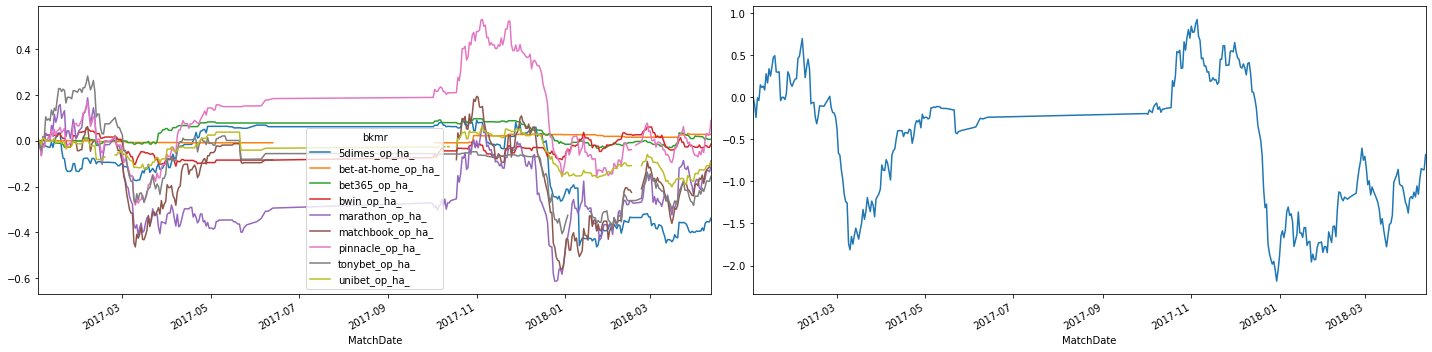

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1])
plt.tight_layout()

In [17]:
aux.head()

level_4  \
MatchDate  HomeTeam           AwayTeam        bkmr                          
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_             0   
                                              5dimes_op_ha_             1   
                                              bet-at-home_op_ha_        0   
                                              bet-at-home_op_ha_        1   
                                              bet365_op_ha_             0   

                                                                   odd  \
MatchDate  HomeTeam           AwayTeam        bkmr                       
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_       4.15   
                                              5dimes_op_ha_       1.26   
                                              bet-at-home_op_ha_  4.22   
                                              bet-at-home_op_ha_  1.22   
                                              bet365_op_ha_       4.20   

                                                                      prob  \
MatchDate  HomeTeam           AwayTeam        bkmr                           
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_       0.215339   
                                              5dimes_op_ha_       0.784661   
                                              bet-at-home_op_ha_  0.208016   
                                              bet-at-home_op_ha_  0.791984   
                                              bet365_op_ha_       0.215339   

                                                                  FTR  frac  \
MatchDate  HomeTeam           AwayTeam        bkmr                            
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_         1   0.0   
                                              5dimes_op_ha_         1   0.0   
                                              bet-at-home_op_ha_    1   0.0   
                                              bet-at-home_op_ha_    1   0.0   
                                              bet365_op_ha_         1   0.0   

                                                                  margin  
MatchDate  HomeTeam           AwayTeam        bkmr                        
2017-01-02 Los Angeles Lakers Toronto Raptors 5dimes_op_ha_         -0.0  
                                              5dimes_op_ha_          0.0  
                                              bet-at-home_op_ha_    -0.0  
                                              bet-at-home_op_ha_     0.0  
                                              bet365_op_ha_         -0.0

In [18]:
tst = aux[aux.index.get_level_values(3) == 'pinnacle_op_ha_']

In [19]:
team = pd.concat([tst.margin.groupby(level=1).mean(), tst.margin.groupby(level=2).mean()], axis=0)

In [20]:
selection = team.groupby(level=0).mean().sort_values(ascending=False).iloc[2:9]

In [21]:
selection

Charlotte Hornets         0.001290
Dallas Mavericks          0.000790
Detroit Pistons           0.000746
Boston Celtics            0.000639
Cleveland Cavaliers       0.000386
Minnesota Timberwolves    0.000321
Indiana Pacers            0.000314
Name: margin, dtype: float64

In [22]:
tst = aux[((aux.index.get_level_values(1).isin(selection.index)) | 
           (aux.index.get_level_values(2).isin(selection.index)))&
           (aux.index.get_level_values(3) == 'pinnacle_op_ha_')]

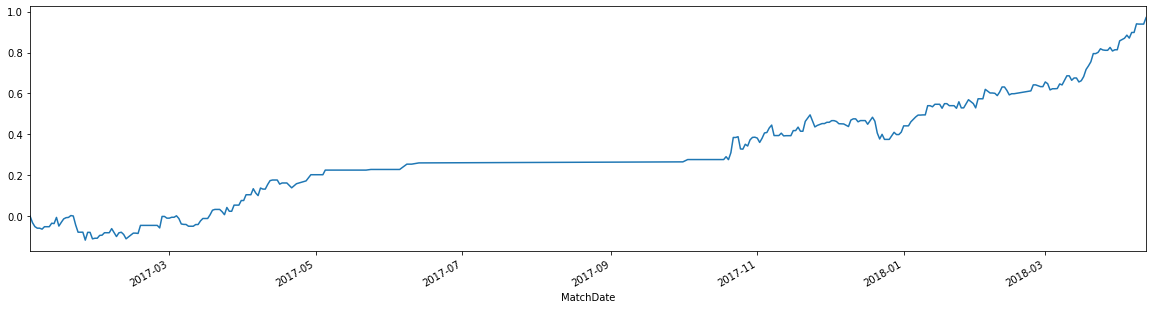

In [23]:
tst.margin.groupby(level=0).sum().cumsum().plot(figsize=(20, 5))

In [24]:
selection

Charlotte Hornets         0.001290
Dallas Mavericks          0.000790
Detroit Pistons           0.000746
Boston Celtics            0.000639
Cleveland Cavaliers       0.000386
Minnesota Timberwolves    0.000321
Indiana Pacers            0.000314
Name: margin, dtype: float64

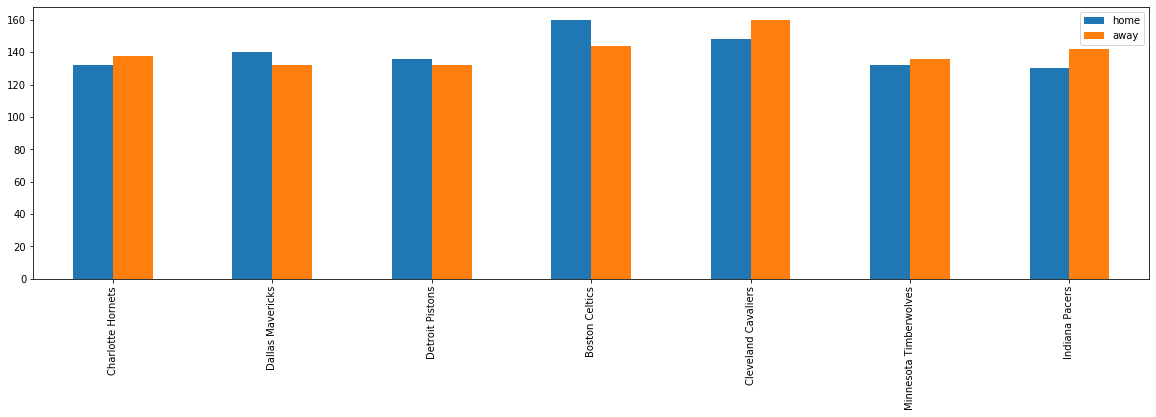

In [26]:
team_counts.plot.bar(figsize=(20, 5))